In [2]:
import numpy as np
import os
import pandas as pd
import neurokit2 as nk
from scipy.signal import find_peaks
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Ignore the warning

In [3]:
root_directory = r"C:\Users\leagi\Documents\EI22\Projet Ecole\data\Préprocessing"

In [4]:
#detecte tous les pics du signal ecg nécessairent à l'extraction des features
def get_peak_ecg(ecg_clean, fig, sampling_rate=500):
    # Extract R-peaks locations
    _, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate, correct_artifacts=True) #R peaks
    _, waves_peak = nk.ecg_delineate(ecg_clean, rpeaks, sampling_rate, method="peak", show=fig, show_type='peaks') #T,P,S peaks    

    #création du dataframe contenant la position des peaks dans le signal
    peaks_df = pd.DataFrame(data = [rpeaks['ECG_R_Peaks'],
                                    waves_peak['ECG_T_Peaks'],
                                    waves_peak['ECG_P_Peaks'],
                                    waves_peak['ECG_S_Peaks']]).T
    
    peaks_df.columns = ['R_peak', 'T_peak', 'P_peak', 'S_peak']

    #possibilité de vérifier l'emplacement des pics
    if fig == True:
        plot = nk.events_plot([rpeaks['ECG_R_Peaks'][:2],
                                waves_peak['ECG_T_Peaks'][:2], 
                                waves_peak['ECG_P_Peaks'][:2],
                                waves_peak['ECG_S_Peaks'][:2]], ecg_clean[:1200])        
        
    return peaks_df   


In [5]:
#extrait tous les motifs en lien avec les pics R
def meanRR(Rpeaks, fig, sampling_rate=500):
    df = nk.hrv(Rpeaks, sampling_rate, show = fig)
    return df

In [6]:
#crée un dataframe avec seulement les motifs des pics R qui nous intérressent
def get_R_features(peak_df, fig, sampling_rate=500):
    feature_RR = nk.hrv(peak_df['R_peak'], sampling_rate, fig)
    
    Rfeatures_df = pd.DataFrame(data = [feature_RR["HRV_MeanNN"],
                                        feature_RR["HRV_MaxNN"],
                                        feature_RR["HRV_MinNN"],
                                        feature_RR["HRV_SDNN"],
                                        feature_RR["HRV_CVNN"],
                                        feature_RR["HRV_SDSD"],
                                        feature_RR["HRV_RMSSD"],
                                        feature_RR["HRV_CVSD"],
                                        feature_RR["HRV_MedianNN"],
                                        feature_RR["HRV_MadNN"],
                                        feature_RR["HRV_MCVNN"],
                                        feature_RR["HRV_IQRNN"],
                                        feature_RR["HRV_pNN50"],
                                        feature_RR["HRV_pNN20"],
                                        feature_RR["HRV_TINN"],
                                        feature_RR["HRV_HTI"],
                                        feature_RR["HRV_LF"],
                                        feature_RR["HRV_HF"],
                                        feature_RR["HRV_VHF"],
                                        feature_RR["HRV_LFHF"],
                                        feature_RR["HRV_SD1"],
                                        feature_RR["HRV_SD2"],
                                        feature_RR["HRV_SD1SD2"],
                                        feature_RR["HRV_ApEn"],
                                        feature_RR["HRV_SampEn"],]).T

    Rfeatures_df.columns = ['MeanNN','MaxNN', 'MinNN', 'SDNN', 'CVNN', 'SDSD', 'RMSSD', 'CVSD', 'MedianNN', 'MadNN', 'MCVNN', 'IQRNN', 'pNN50', 'pNN20', 'TINN', 'HTI', 'LF', 'HF', 'VHF', 'LFHF', 'SD1', 'SD2', 'SD1SD2', 'ApEn', 'SampEn']
    return Rfeatures_df

In [7]:
#Calcul des motifs sur les pics S,T,P + création du dataframe
def sd_mean_PR_ST_PT(peak_df):
    List_PR = []
    List_ST = []
    List_PT = []
    n = len(peak_df)
    
    for i in range(1, n-1):
        if np.isnan(peak_df['R_peak'][i])== False and np.isnan(peak_df['P_peak'][i])==False:
            List_PR.append(peak_df['R_peak'][i]-peak_df['P_peak'][i])
            
        if np.isnan(peak_df['T_peak'][i])== False and np.isnan(peak_df['S_peak'][i])==False:
            List_ST.append(peak_df['T_peak'][i]-peak_df['S_peak'][i])
            
        if np.isnan(peak_df['T_peak'][i])== False and np.isnan(peak_df['P_peak'][i])==False:
            List_PT.append(peak_df['T_peak'][i]-peak_df['P_peak'][i])
            
    Mean_PR = sum(List_PR)/len(List_PR)
    Mean_ST = sum(List_ST)/len(List_ST)
    Mean_PT = sum(List_PT)/len(List_PT)

    SD_PR = np.std(List_PR)
    SD_ST = np.std(List_ST)
    SD_PT = np.std(List_PT)
    
    Mean_feature = pd.DataFrame(data = [Mean_PR, SD_PR, Mean_ST, SD_ST, Mean_PT, SD_PT]).T
    Mean_feature.columns = ['MeanPR','PR sd', 'MeanST', 'ST sd', 'MeanPT', 'PT sd']
    
    return Mean_feature

In [8]:
#Calcul des motifs concernant le ryhtme cardiaque + création du dataframe
def HR_feature(ecg_signal_df):
    Mean_HR = sum(ecg_signal_df['Heart_Rate'])/len(ecg_signal_df)
    SD_HR = np.std(ecg_signal_df['Heart_Rate'])
    Max_HR = max(ecg_signal_df['Heart_Rate'])
    Min_HR = min(ecg_signal_df['Heart_Rate'])

    
    HR_feature = pd.DataFrame(data = [Mean_HR, SD_HR, Max_HR, Min_HR]).T
    HR_feature.columns = ['MeanHR','HR sd', 'MaxHR', 'MinHR']

    return HR_feature

In [9]:
#Création du dataframe complet des motifs pour chaque signaux
def get_all_features(ecg_signal_df, filter_clean, fig, sampling_rate):
    #filter_clean = True alors on utilise les données filtrée par notre filtre
    # si = False alors on utilise la colonne clean de neurokit
    if filter_clean:
        All_Peaks_df = get_peak_ecg(ecg_signal_df['ECG_Filtered'], fig, sampling_rate)
    else :
        All_Peaks_df = get_peak_ecg(ecg_signal_df['ECG_Clean'], fig, sampling_rate)
        
    R_features_df = get_R_features(All_Peaks_df, fig, sampling_rate)
    HR_feature_df = HR_feature(ecg_signal_df)
    Mean_feature = sd_mean_PR_ST_PT(All_Peaks_df)
    
    Feature = pd.concat([HR_feature_df,R_features_df, Mean_feature], axis=1)
    
    return Feature

In [10]:
#Extraction des motifs ecg de toute la base de donnée
def extract_features_all_datas(root_folder):
    all_feature = pd.DataFrame(columns=['ID','Task','MeanHR','HR sd','MaxHR','MinHR','MeanNN','MaxNN','MinNN','SDNN','SDSD','CVNN','RMSSD','CVSD','MedianNN','MadNN','MCVNN','IQRNN','pNN50','pNN20','TINN','HTI','LF','HF','VHF','LFHF','SD1','SD2','SD1SD2','ApEn','SampEn','MeanPR','PR sd','MeanST','ST sd','MeanPT','PT sd'])

    #parcours de toute la base de donnée filtrée
    for root, dirs, files in os.walk(root_folder):
        for file in tqdm(files, total=len(files)):
            # Extract the individual ID and task from the file name
            file_parts = file.split('_')
            id = file_parts[0]  
            task = file_parts[1] 
            
            try:
                ecg_data = pd.read_csv(os.path.join(root, file), sep=';')
                
                #Filtrage avec la librairie neurokit2
                signal_cleaned, infos =nk.ecg_process(ecg_data["ECG_Raw"], 500, method='neurokit')
                #nk.ecg_plot(signal_cleaned, infos)
                
                #ajout de la colonne dans le dataframe
                ecg_data.insert(loc=3, column='ECG_Clean', value=signal_cleaned['ECG_Clean'])
                ecg_data.insert(loc=4, column='Heart_Rate', value=signal_cleaned['ECG_Rate'])

                #Création du dataframe de features avec les id et task
                data_features = get_all_features(ecg_data, True, False, 500)
                data_features.insert(loc=0, column='ID', value=id)
                data_features.insert(loc=1, column='Task', value=task)
                
                all_feature = pd.concat([all_feature, data_features], ignore_index=True)
                
            except Exception as e:
                print(f"Error reading file {file}: {e}")

    #enregistrement du dataframe des motifs de tous les fichiers
    all_feature.to_csv(r'C:\Users\leagi\Documents\EI22\Projet Ecole\data\Features\ECG_features.csv',sep=';', index=False)

    return all_feature

In [11]:
df = extract_features_all_datas(root_directory)

0it [00:00, ?it/s]
  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\leagi\AppData\Local\Temp\ipykernel_7504\3335846670.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_feature = pd.concat([all_feature, data_features], ignore_index=True)
100%|██████████| 12/12 [00:32<00:00,  2.72s/it]


Tester avec un seul fichier =================================================================================================================

,Time,ECG_Raw,ECG_Filtered,ECG_Clean,Heart_Rate
0,0.000,32040,-249.826440,-121.261840,60.494207
1,0.000,31866,-261.401581,-134.365511,60.494207
2,0.002,31656,-270.948699,-144.268365,60.494207
3,0.004,31648,-277.015504,-149.409665,60.494207
4,0.006,31712,-278.325340,-149.338752,60.494207
...,...,...,...,...,...
29995,59.988,32244,-77.093438,179.479109,65.075922
29996,59.990,32260,-73.853443,188.160089,65.075922
29997,59.992,32324,-71.165207,193.845207,65.075922
29998,59.994,32320,-68.900274,195.182776,65.075922


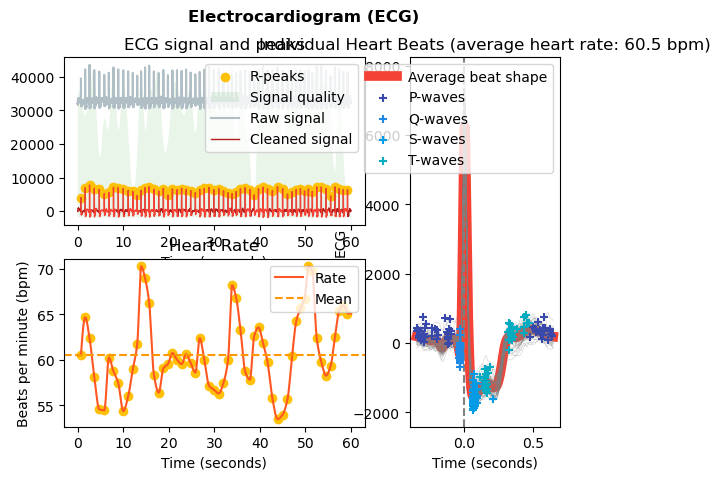

In [12]:
signal_filtered=pd.read_csv(r'C:\Users\leagi\Documents\EI22\Projet Ecole\data\Préprocessing\2ea4\2ea4_Stroop_ecg_data_filtered.csv', sep=";")
#Filtrage avec la librairie neurokit2
signal_cleaned, infos =nk.ecg_process(signal_filtered["ECG_Raw"], 500, method='neurokit')
nk.ecg_plot(signal_cleaned, infos)


#ajout de la colonne dans le dataframe
signal_filtered.insert(loc=3, column='ECG_Clean', value=signal_cleaned['ECG_Clean'])
signal_filtered.insert(loc=4, column='Heart_Rate', value=signal_cleaned['ECG_Rate'])
signal_filtered

Text(0, 0.5, 'Amplitude')

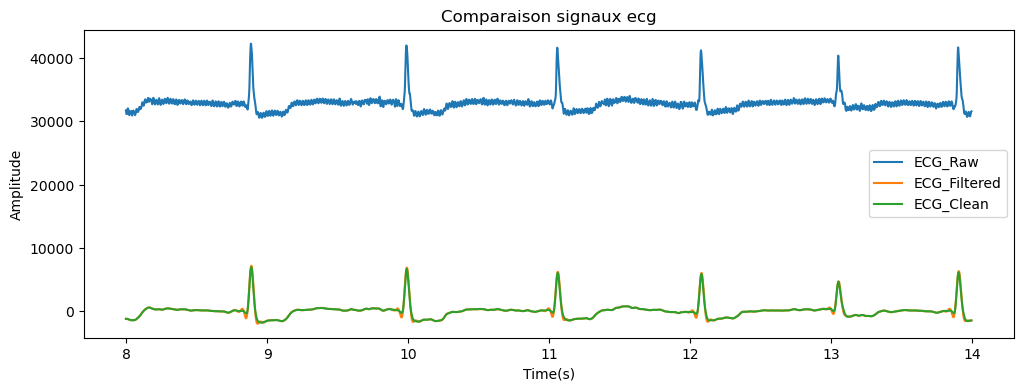

In [13]:
signal_filtered[4000:7000].plot(x="Time", y=["ECG_Raw", "ECG_Filtered", "ECG_Clean"], title="Comparaison signaux ecg",figsize=(12,4))
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")

,MeanHR,HR sd,MaxHR,MinHR,MeanNN,MaxNN,MinNN,SDNN,CVNN,SDSD,...,SD2,SD1SD2,ApEn,SampEn,MeanPR,PR sd,MeanST,ST sd,MeanPT,PT sd
0,60.544591,4.088709,70.257611,53.475936,991.79661,1124.0,852.0,68.641693,0.069209,51.389795,...,90.049664,0.403534,0.400701,3.044522,35.465517,12.608448,156.051724,69.782772,218.724138,68.493844


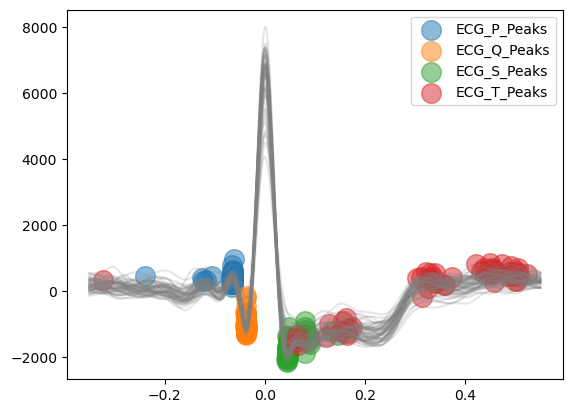

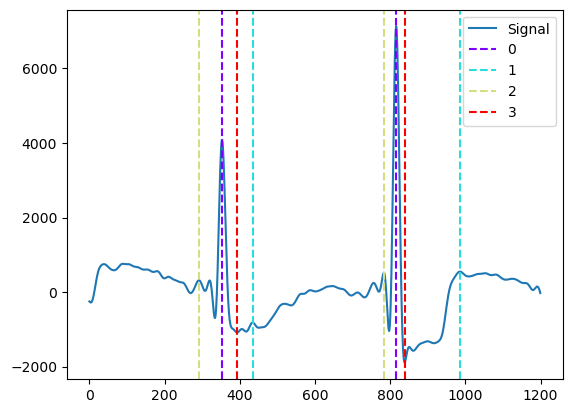

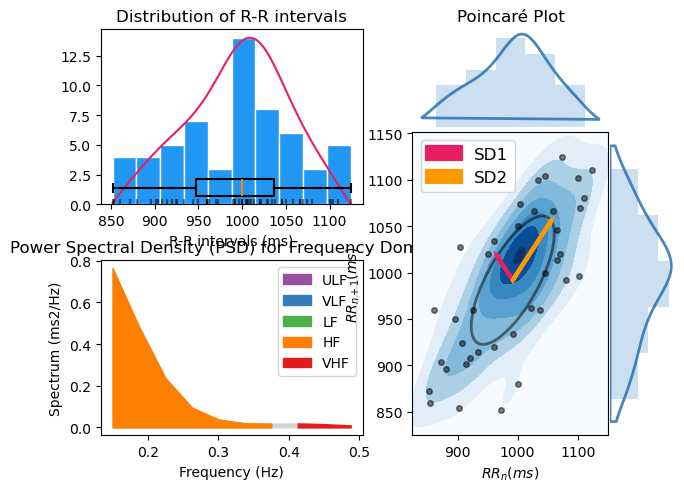

In [14]:
feature=get_all_features(signal_filtered, True, True, 500)
#feature.to_csv('feature.csv',sep=';', index=False)
feature